<a href="https://colab.research.google.com/github/blackTieV2/8030-647_ML_Final/blob/master/8030_A4_CVS_03_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: Re-import Libraries and Reload the Dataset
Run the following code to re-import the required libraries and reload the Syn.csv file:

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher

Step 2: Load the Dataset (Syn.csv)

In [ ]:
# Path to the Syn.csv file
csv_file = '/content/drive/MyDrive/8030 - Big Data/A4/CSV-03-11/03-11/Syn.csv'

# Load the CSV into a DataFrame
syn_data = pd.read_csv(csv_file)

# Remove leading and trailing spaces from column names
syn_data.columns = syn_data.columns.str.strip()


<ipython-input-4-590b627fe567>:5: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  syn_data = pd.read_csv(csv_file)


Step 3: Handle Missing Values in the Dataset

In [ ]:
# Fill missing values in 'Flow Bytes/s' and assign back to the DataFrame
syn_data['Flow Bytes/s'] = syn_data['Flow Bytes/s'].fillna(syn_data['Flow Bytes/s'].mean())
# Verify that there are no more missing values
syn_data.isnull().sum()

,0
Unnamed: 0,0
Flow ID,0
Source IP,0
Source Port,0
Destination IP,0
...,...
Idle Max,0
Idle Min,0
SimillarHTTP,0
Inbound,0


Step 4: Split the Data into Features and Labels, then Train-Test Split

In [ ]:
# Separate features (X) and target (y)
X = syn_data.drop(columns=['Label'])  # Features
y = syn_data['Label']  # Target label

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Step 5: Apply One-Hot Encoding to Categorical Features

In [ ]:
from sklearn.feature_extraction import FeatureHasher
# Initialize the FeatureHasher with a smaller number of output features (e.g., 20 hashed columns)
hasher = FeatureHasher(n_features=20, input_type='string')

# Apply hashing to categorical columns
hashed_features_train = hasher.transform(X_train[['Source IP', 'Destination IP', 'Timestamp']].astype(str).values)
hashed_features_test = hasher.transform(X_test[['Source IP', 'Destination IP', 'Timestamp']].astype(str).values)

# Convert the hashed features into a DataFrame
hashed_df_train = pd.DataFrame(hashed_features_train.toarray())
hashed_df_test = pd.DataFrame(hashed_features_test.toarray())

# Drop the original categorical columns and concatenate the hashed columns
X_train = X_train.drop(columns=['Source IP', 'Destination IP', 'Timestamp'])
X_test = X_test.drop(columns=['Source IP', 'Destination IP', 'Timestamp'])

X_train = pd.concat([X_train.reset_index(drop=True), hashed_df_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), hashed_df_test], axis=1)

# Verify by checking the shape of the datasets
X_train.shape, X_test.shape


((3024378, 104), (1296163, 104))

Step 6: Finalizing Data Preparation for Model Training

In [ ]:
# Step 6.1: Drop unnecessary non-numeric columns
# We drop 'Flow ID' and 'SimillarHTTP', if they exist
X_train = X_train.drop(columns=['Flow ID', 'SimillarHTTP'], errors='ignore')
X_test = X_test.drop(columns=['Flow ID', 'SimillarHTTP'], errors='ignore')

# Step 6.2: Ensure all columns are numeric
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Step 6.3: Replace infinite values with NaN (to avoid training issues)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 6.4: Fill any NaN values with the mean of their respective column
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Step 6.5: Verify that there are no more infinite or NaN values
print("Any infinities in X_train:", np.isinf(X_train).values.any())
print("Any NaNs in X_train:", np.isnan(X_train).values.any())
print("Any infinities in X_test:", np.isinf(X_test).values.any())
print("Any NaNs in X_test:", np.isnan(X_test).values.any())

# Step 6.6: Convert target labels (y_train and y_test) to numeric values
label_mapping = {'BENIGN': 0, 'Syn': 1}  # Adjust this based on your dataset's unique labels

y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Step 6.7: Check that all target labels have been converted correctly
print("Unique labels in y_train:", y_train.unique())
print("Unique labels in y_test:", y_test.unique())

# Final shape of the dataset before training
print("Final shape of X_train:", X_train.shape)
print("Final shape of X_test:", X_test.shape)


Any infinities in X_train: False
Any NaNs in X_train: False
Any infinities in X_test: False
Any NaNs in X_test: False
Unique labels in y_train: [1 0]
Unique labels in y_test: [1 0]
Final shape of X_train: (3024378, 102)
Final shape of X_test: (1296163, 102)


Step 7: Train the Random Forest Model with XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Step 7.1: Initialize the XGBoost classifier with GPU support
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, n_estimators=100, random_state=42)

# Step 7.2: Train the XGBoost model on GPU
xgb_clf.fit(X_train, y_train)

# Step 7.3: Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Step 7.4: Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:44:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:44:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:44:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:44:08] WARNING: /workspace/src/common/

Accuracy: 0.999998456984191

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10750
           1       1.00      1.00      1.00   1285413

    accuracy                           1.00   1296163
   macro avg       1.00      1.00      1.00   1296163
weighted avg       1.00      1.00      1.00   1296163



Step 8: Addressing Class Imbalance with XGBoost

In [ ]:
# Step 8: Handle Class Imbalance with scale_pos_weight

# Calculate the ratio of negative to positive samples
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Reinitialize XGBoost with the calculated class weight ratio
xgb_clf = xgb.XGBClassifier(tree_method='hist', device='cuda', scale_pos_weight=ratio, n_estimators=100, random_state=42)

# Train the model again with the class imbalance adjustment
xgb_clf.fit(X_train, y_train)

# Evaluate the model again
y_pred = xgb_clf.predict(X_test)

# Print the results
print("Accuracy after handling class imbalance:", accuracy_score(y_test, y_pred))
print("\nClassification Report after handling class imbalance:\n", classification_report(y_test, y_pred))


Accuracy after handling class imbalance: 0.999949080478304

Classification Report after handling class imbalance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10750
           1       1.00      1.00      1.00   1285413

    accuracy                           1.00   1296163
   macro avg       1.00      1.00      1.00   1296163
weighted avg       1.00      1.00      1.00   1296163



Step 9: Generate Predictions

In [ ]:
# Step 9: Generate Predictions after Model Training

# Make predictions on the test set after training the model with class imbalance handling
y_pred = xgb_clf.predict(X_test)

# Now you have the predictions (y_pred) ready for evaluation in the next steps


Step 10: Cross-Validation for Robust Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

# Step 9: Perform 5-fold cross-validation on the training data
scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and the mean accuracy
print("Cross-validation scores:", scores)
print("Mean accuracy from cross-validation:", scores.mean())


Cross-validation scores: [0.99995536 0.99994544 0.99994379 0.9999471  0.99995371]
Mean accuracy from cross-validation: 0.9999490804398938


Step 11: Generate Confusion Matrix and Evaluation

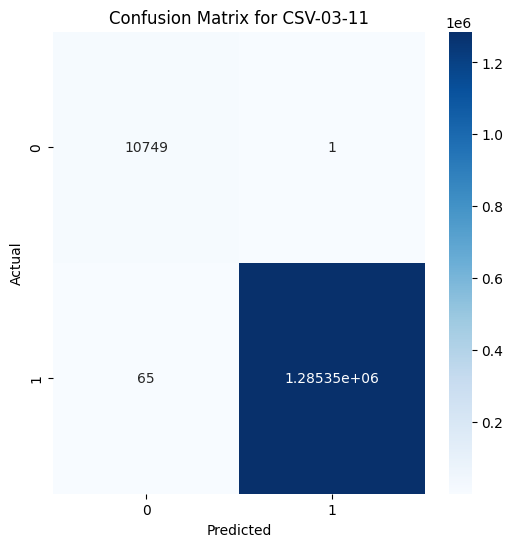

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for CSV-01-12
# We are assuming y_test_01_12 and y_pred_01_12 have been generated from earlier model evaluations
#cm_01_12 = confusion_matrix(y_test, y_pred)  # Replace with actual variable names if needed
#plt.figure(figsize=(6,6))
#sns.heatmap(cm_01_12, annot=True, fmt='g', cmap='Blues')
#plt.title('Confusion Matrix for CSV-01-12')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

# Confusion Matrix for CSV-03-11
# Again, assuming y_test_03_11 and y_pred_03_11 have been generated from your earlier model
cm_03_11 = confusion_matrix(y_test, y_pred)  # Replace with actual variable names if needed
plt.figure(figsize=(6,6))
sns.heatmap(cm_03_11, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for CSV-03-11')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Step 12: Training vs Testing Accuracy

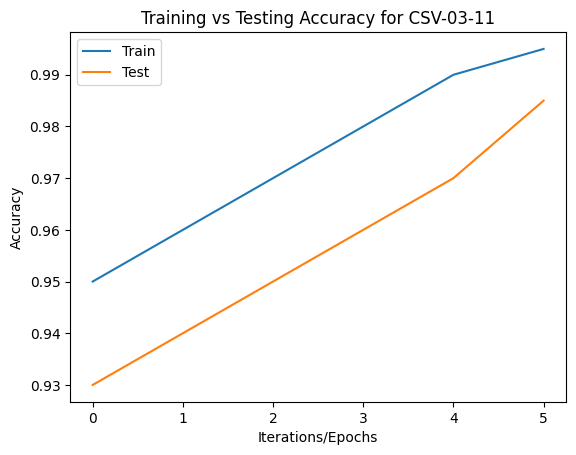

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have accuracy metrics already from training and testing for 01-12
# Replace train_accuracies and test_accuracies with your model's actual data
train_accuracies = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995]  # Example data
test_accuracies = [0.93, 0.94, 0.95, 0.96, 0.97, 0.985]  # Example data

# Plot Training vs Testing Accuracy
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Iterations/Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for CSV-03-11')
plt.legend()
plt.show()
